# Mammography

## Introduction
Mammography is the most effective method for breast cancer screening available today. However, the low positive predictive value of breast biopsy resulting from mammogram interpretation leads to approximately 70% unnecessary biopsies with benign outcomes. To reduce the high number of unnecessary breast biopsies, several computer-aided diagnosis (CAD) systems have been proposed in the last years.These system help physicians in their decision to perform a breast biopsy on a suspicious lesion seen in a mammogram or to perform a short term follow-up examination instead. This data set can be used to predict the severity (benign or malignant) of a mammographic mass lesion from BI-RADS attributes and the patient's age. It contains a BI-RADS assessment, the patient's age and three BI-RADS attributes together with the ground truth (the severity field) for 516 benign and 445 malignant masses that have been identified on full field digital mammograms collected at the Institute of Radiology of the University Erlangen-Nuremberg between 2003 and 2006. Each instance has an associated BI-RADS assessment ranging from 1 (definitely benign) to 5 (highly suggestive of malignancy) assigned in a double-review process by physicians. Assuming that all cases with BI-RADS assessments greater or equal a given value (varying from 1 to 5), are malignant and the other cases benign, sensitivities and associated specificities can be calculated. These can be an indication of how well a CAD system performs compared to the radiologists. For more details visit https://archive.ics.uci.edu/dataset/161/mammographic+mass.

## Exploring the Mammographic Mass Dataset
The Mammographic Mass dataset contains six attributes, among which there is a target attribute and a non-predictive attribute. The target attribute, denoted as 'Severity', is binomial, distinguishing between benign (0) and malignant (1) cases. The non-predictive attribute, 'BI-RADS assessment', is an ordinal scale ranging from 1 to 5. The remaining four attributes are predictive, including 'Age', represented in years as an integer, 'Shape' categorizing mass shape as round (1), oval (2), lobular (3), or irregular (4). 'Margin' classifies mass margins into circumscribed (1), microlobulated (2), obscured (3), ill-defined (4), or spiculated (5). 'Density' indicates mass density as high (1), iso (2), low (3), or fat-containing (4).

In [7]:
import pandas as pd
import missingno as msno
from sklearn.tree import DecisionTreeClassifier
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import  sklearn.metrics as metrics

In [8]:
# fetch dataset 
mammographic_mass = fetch_ucirepo(id=161) 
  
# data (as pandas dataframes) 
X = mammographic_mass.data.features 
y = mammographic_mass.data.targets 
  
# metadata 
print(mammographic_mass.metadata) 
  
# variable information 
print(mammographic_mass.variables) 


{'uci_id': 161, 'name': 'Mammographic Mass', 'repository_url': 'https://archive.ics.uci.edu/dataset/161/mammographic+mass', 'data_url': 'https://archive.ics.uci.edu/static/public/161/data.csv', 'abstract': "Discrimination of benign and malignant mammographic masses based on BI-RADS attributes and the patient's age.", 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 961, 'num_features': 5, 'feature_types': ['Integer'], 'demographics': ['Age'], 'target_col': ['Severity'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2007, 'last_updated': 'Thu Mar 28 2024', 'dataset_doi': '10.24432/C53K6Z', 'creators': ['Matthias Elter'], 'intro_paper': {'ID': 448, 'type': 'NATIVE', 'title': 'The prediction of breast cancer biopsy outcomes using two CAD approaches that both emphasize an intelligible decision process.', 'authors': 'M. Elter, R. Schulz-Wendtland, T. Wittenberg', 'v

In [9]:
dataset = pd.merge(X,y,right_index=True,left_index=True)

In [10]:
dataset

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1
...,...,...,...,...,...,...
956,4.0,47.0,2.0,1.0,3.0,0
957,4.0,56.0,4.0,5.0,3.0,1
958,4.0,64.0,4.0,5.0,3.0,0
959,5.0,66.0,4.0,5.0,3.0,1


In [11]:
dataset.isnull().sum()

BI-RADS      2
Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

In [12]:
dataset.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [15]:
dataset = dataset.drop(columns=['BI-RADS'],axis=1)

## Data preparation and Visualisation

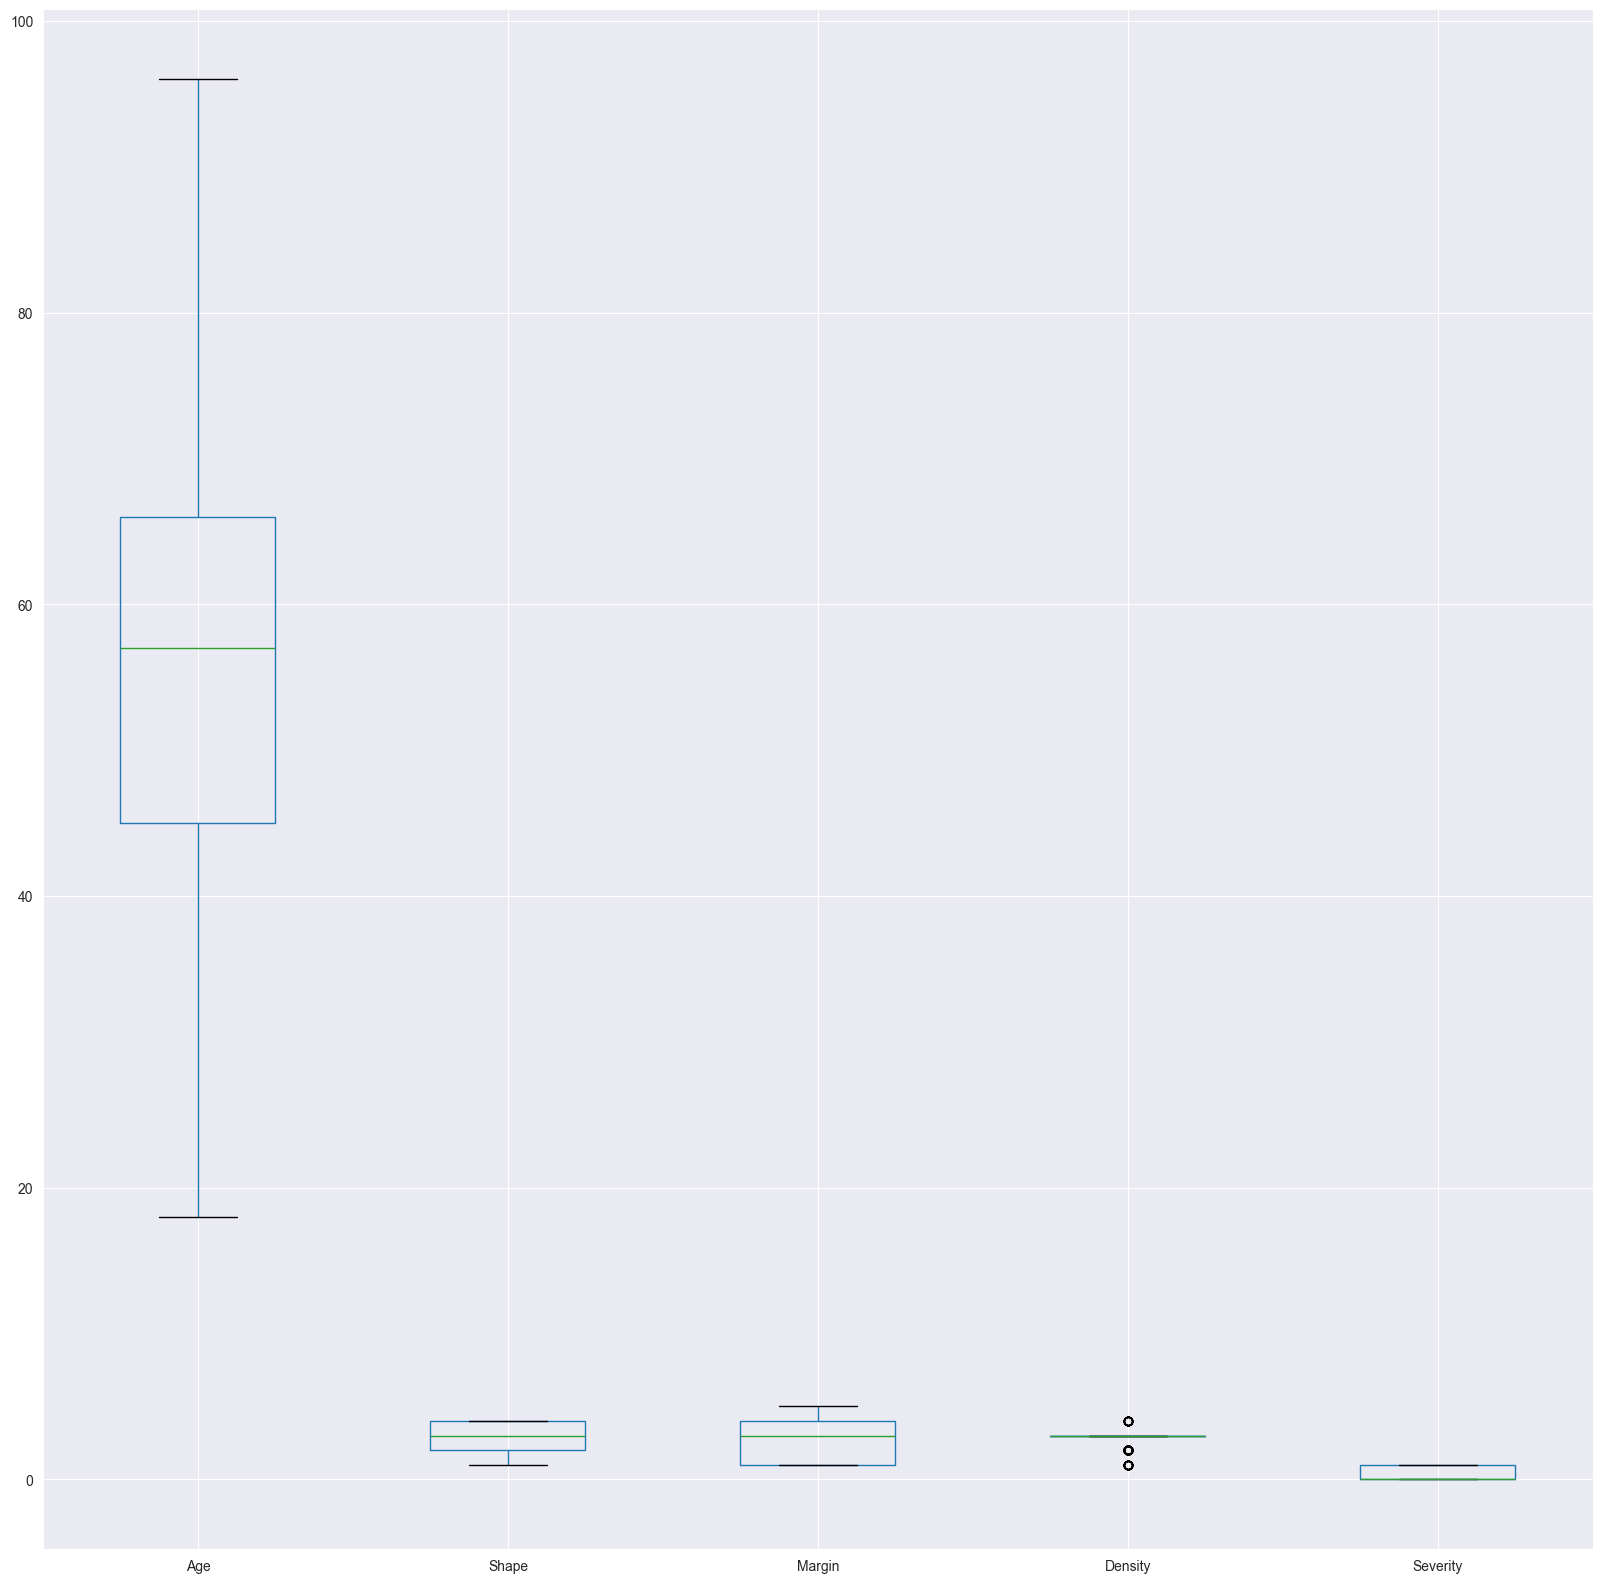

In [19]:
plt.figure(figsize=(20,20))
dataset.boxplot()
plt.show()

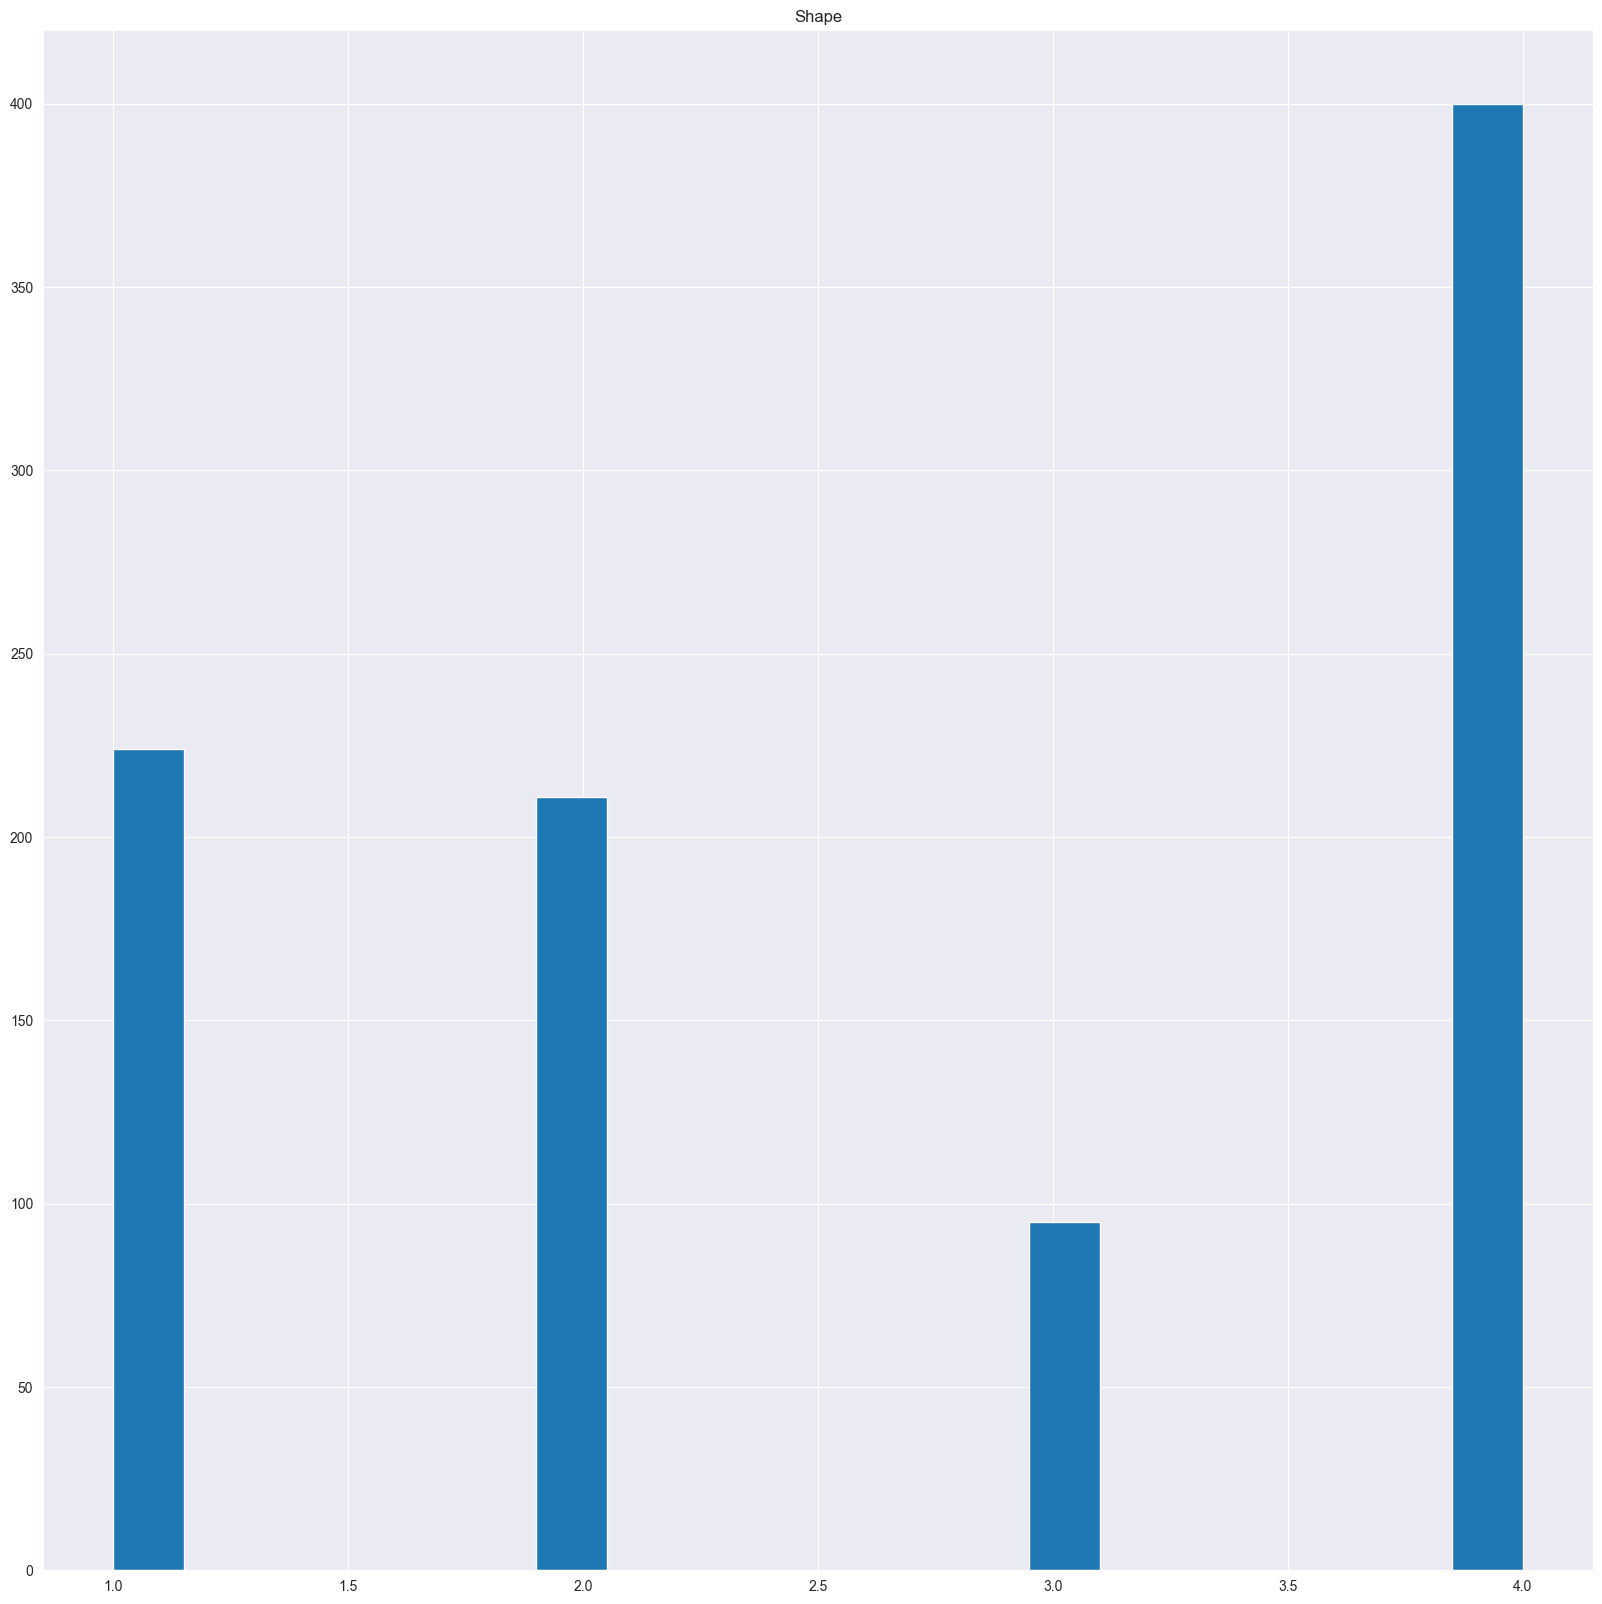

In [17]:
plt.figure(figsize=(20,20))
plt.hist(dataset['Shape'],bins=20)
plt.title("Shape")
plt.show()

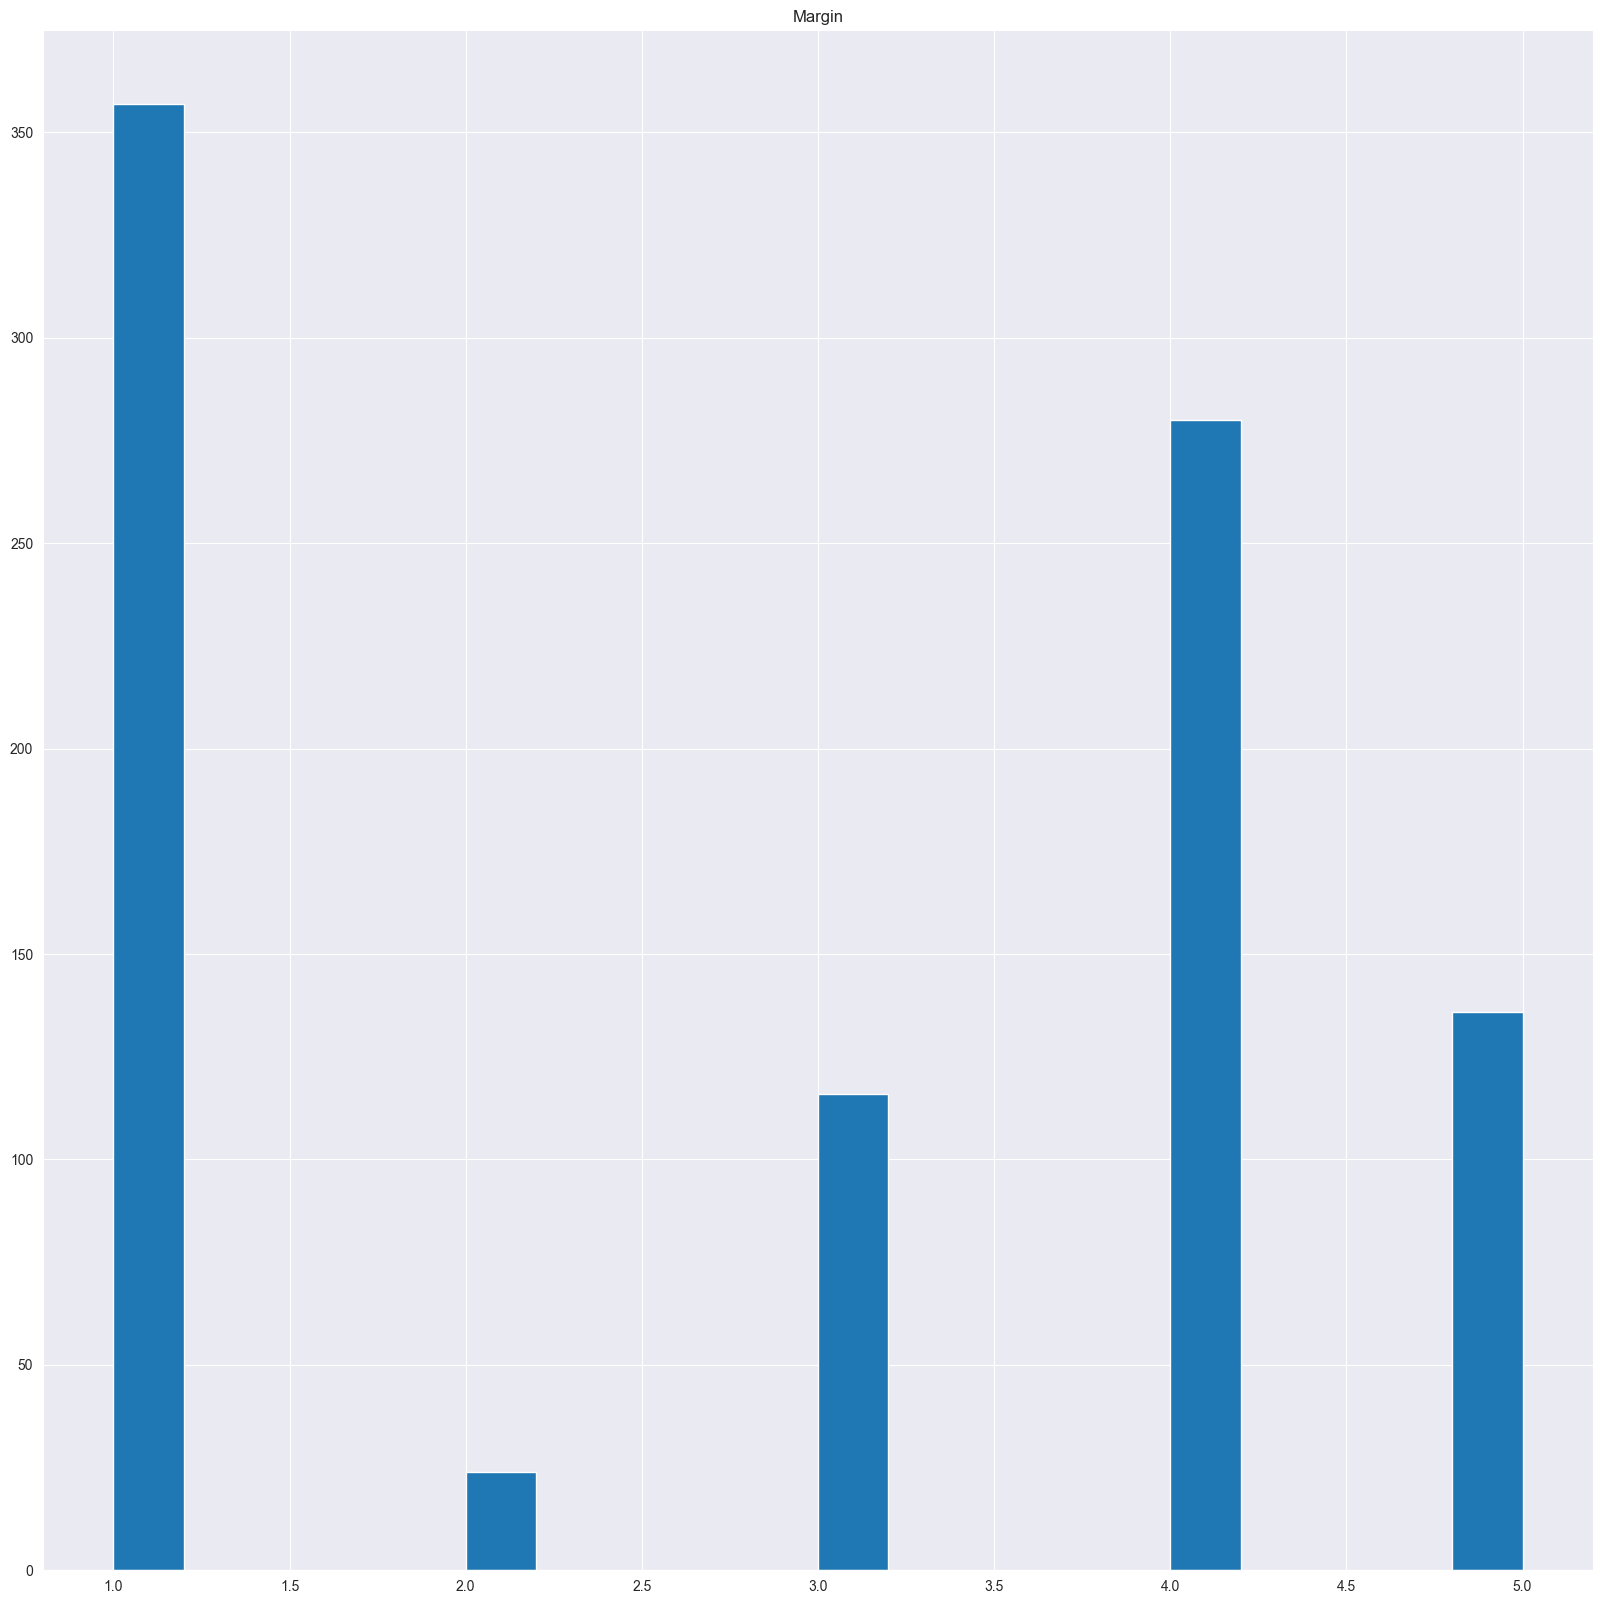

In [20]:
plt.figure(figsize=(20,20))
plt.hist(dataset['Margin'],bins=20)
plt.title("Margin")
plt.show()

(array([ 12.,  17.,  16.,  25.,  41.,  55.,  78.,  75.,  81.,  74., 116.,
         89., 108.,  64.,  45.,  32.,  11.,  15.,   0.,   2.]),
 array([18. , 21.9, 25.8, 29.7, 33.6, 37.5, 41.4, 45.3, 49.2, 53.1, 57. ,
        60.9, 64.8, 68.7, 72.6, 76.5, 80.4, 84.3, 88.2, 92.1, 96. ]),
 <BarContainer object of 20 artists>)

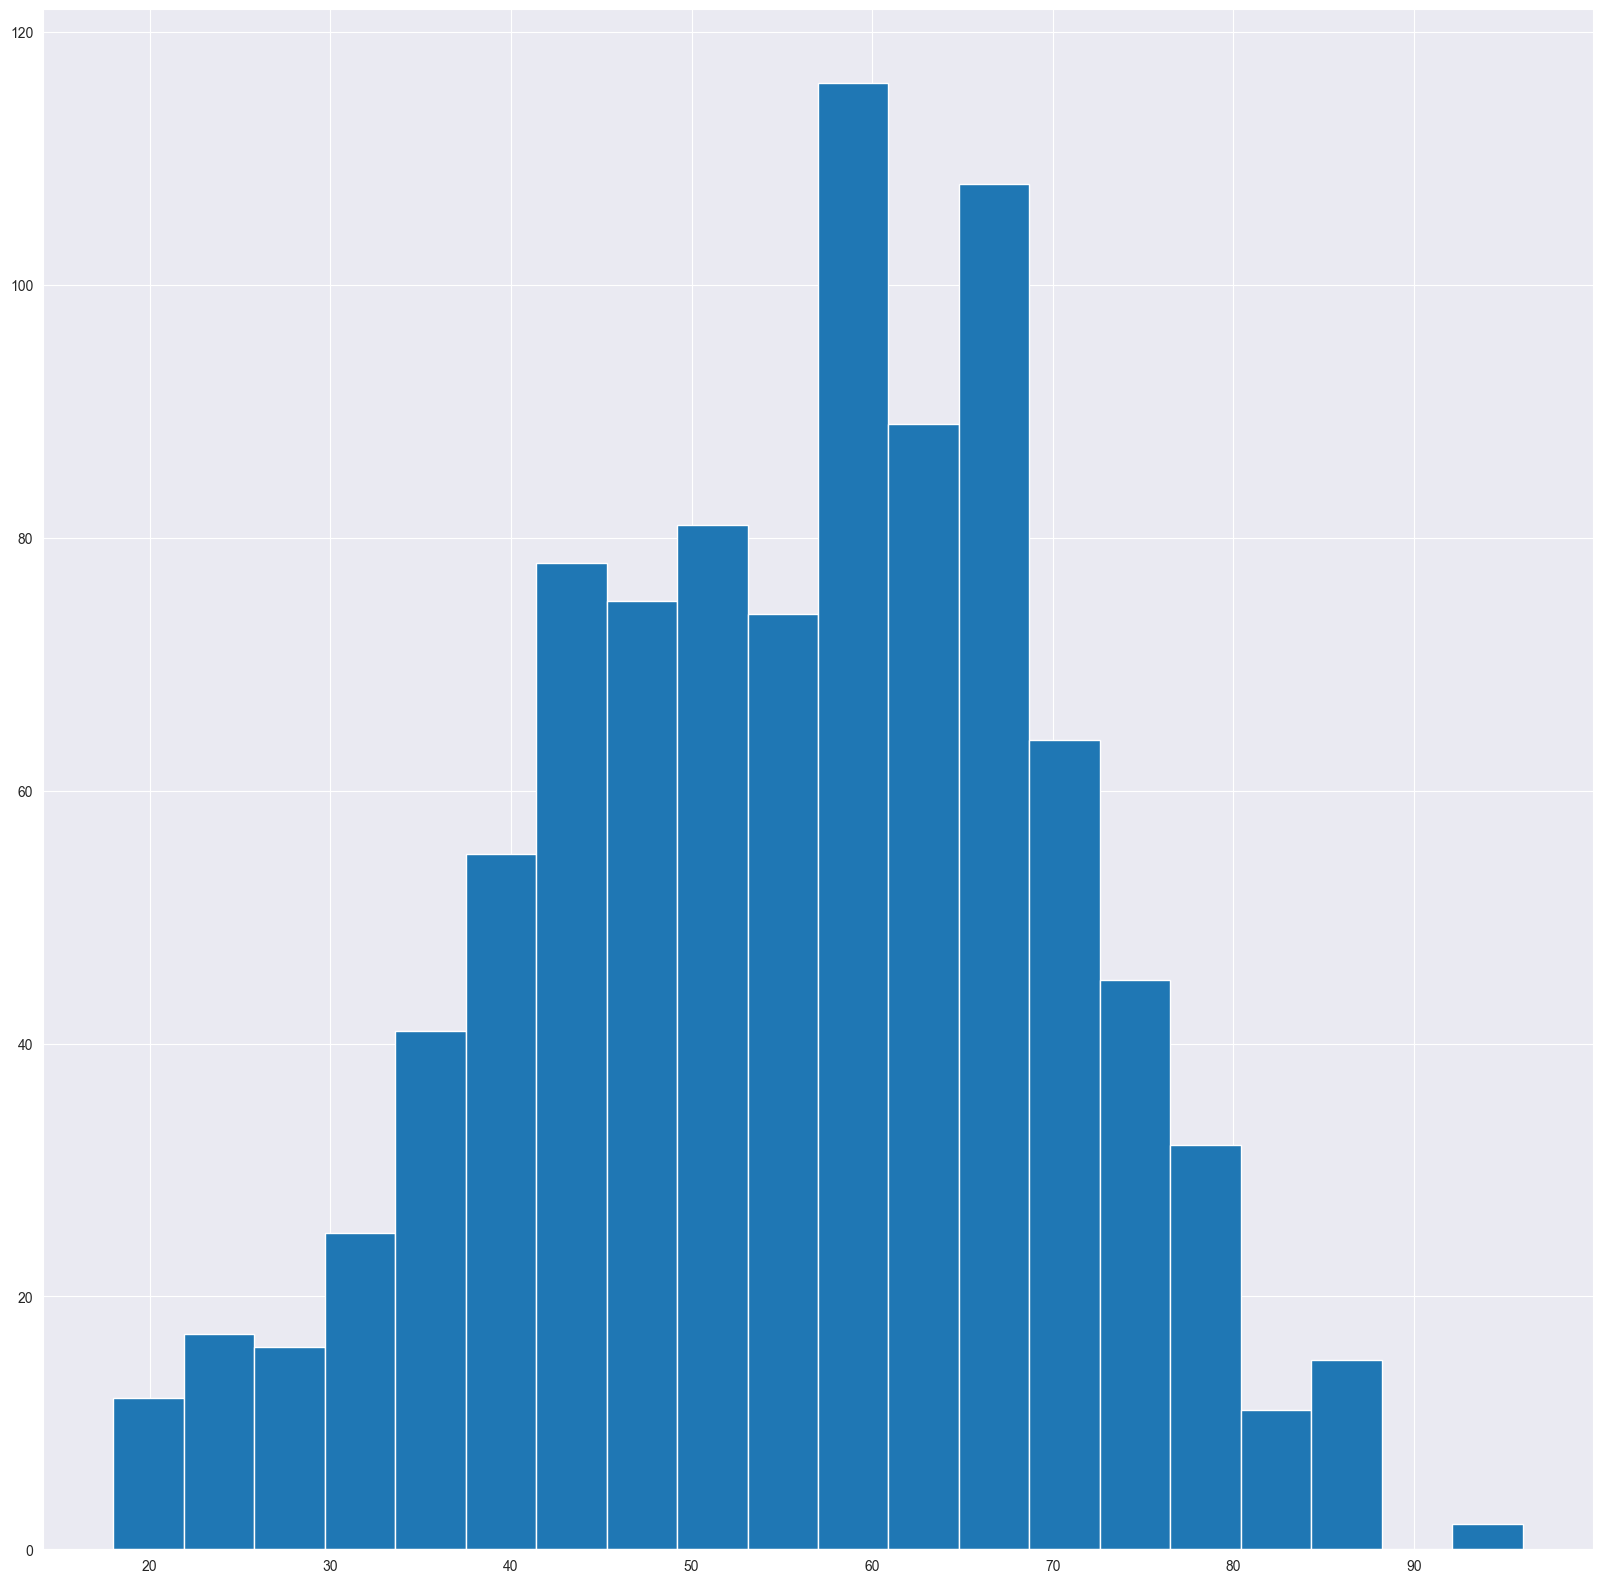

In [8]:
plt.figure(figsize=(20,20))
plt.hist(dataset['Age'],bins=20)

(array([ 16.,   0.,   0.,   0.,   0.,   0.,  59.,   0.,   0.,   0.,   0.,
          0.,   0., 798.,   0.,   0.,   0.,   0.,   0.,  12.]),
 array([1.  , 1.15, 1.3 , 1.45, 1.6 , 1.75, 1.9 , 2.05, 2.2 , 2.35, 2.5 ,
        2.65, 2.8 , 2.95, 3.1 , 3.25, 3.4 , 3.55, 3.7 , 3.85, 4.  ]),
 <BarContainer object of 20 artists>)

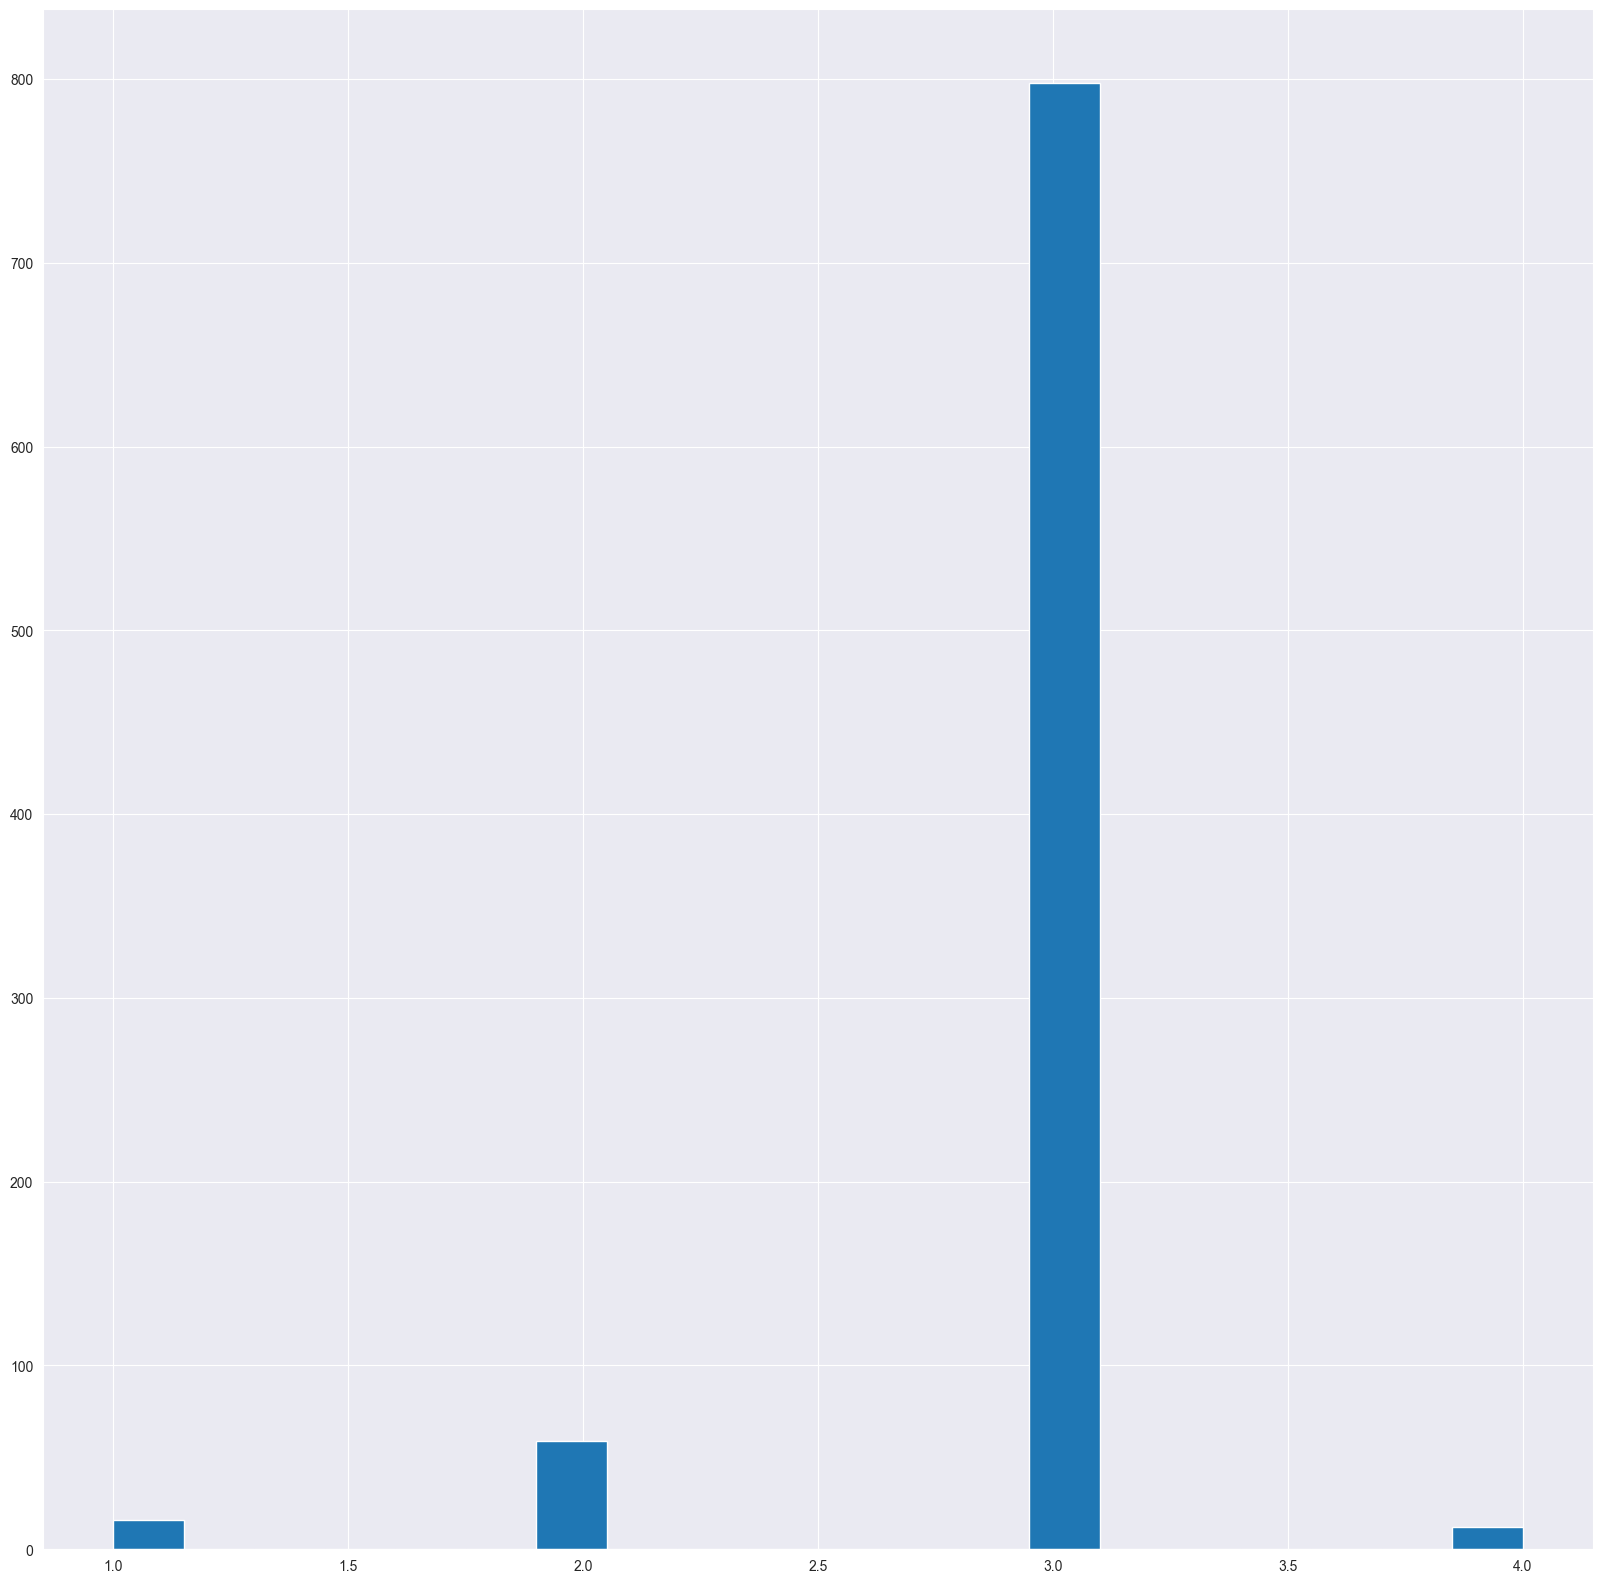

In [23]:
plt.figure(figsize=(20,20))
plt.hist(dataset['Density'],bins=20)

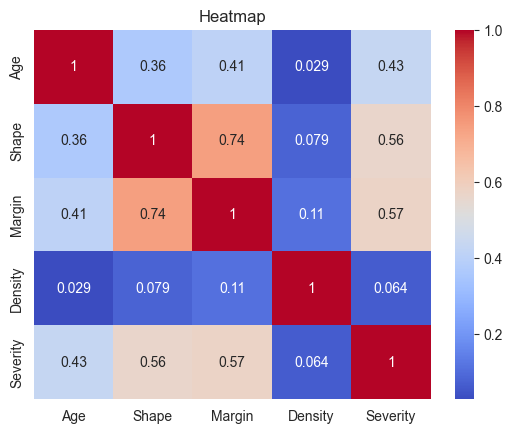

In [24]:
corr_matrix = dataset.corr()
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm')
plt.title('Heatmap')
plt.show()

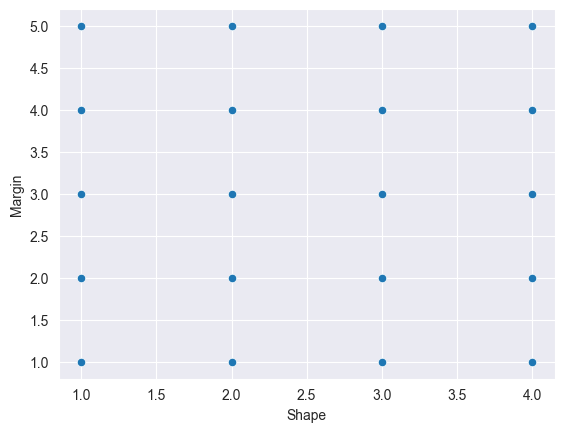

In [25]:
sns.scatterplot(data=dataset,x=dataset['Shape'],y=dataset['Margin'])
plt.show()

Check if the dataset is balanced.

In [27]:
print(f'Severity:{dataset["Severity"].value_counts()}')

Severity:Severity
0    516
1    445
Name: count, dtype: int64


In [28]:
missing_percent = dataset.isnull().sum()/len(dataset)*100
missing_percent = missing_percent.reset_index().rename(columns={"index": "column", 0: "percent missing"})
missing_percent

,column,percent missing
0,Age,0.520291
1,Shape,3.225806
2,Margin,4.994797
3,Density,7.908429
4,Severity,0.000000


<Axes: >

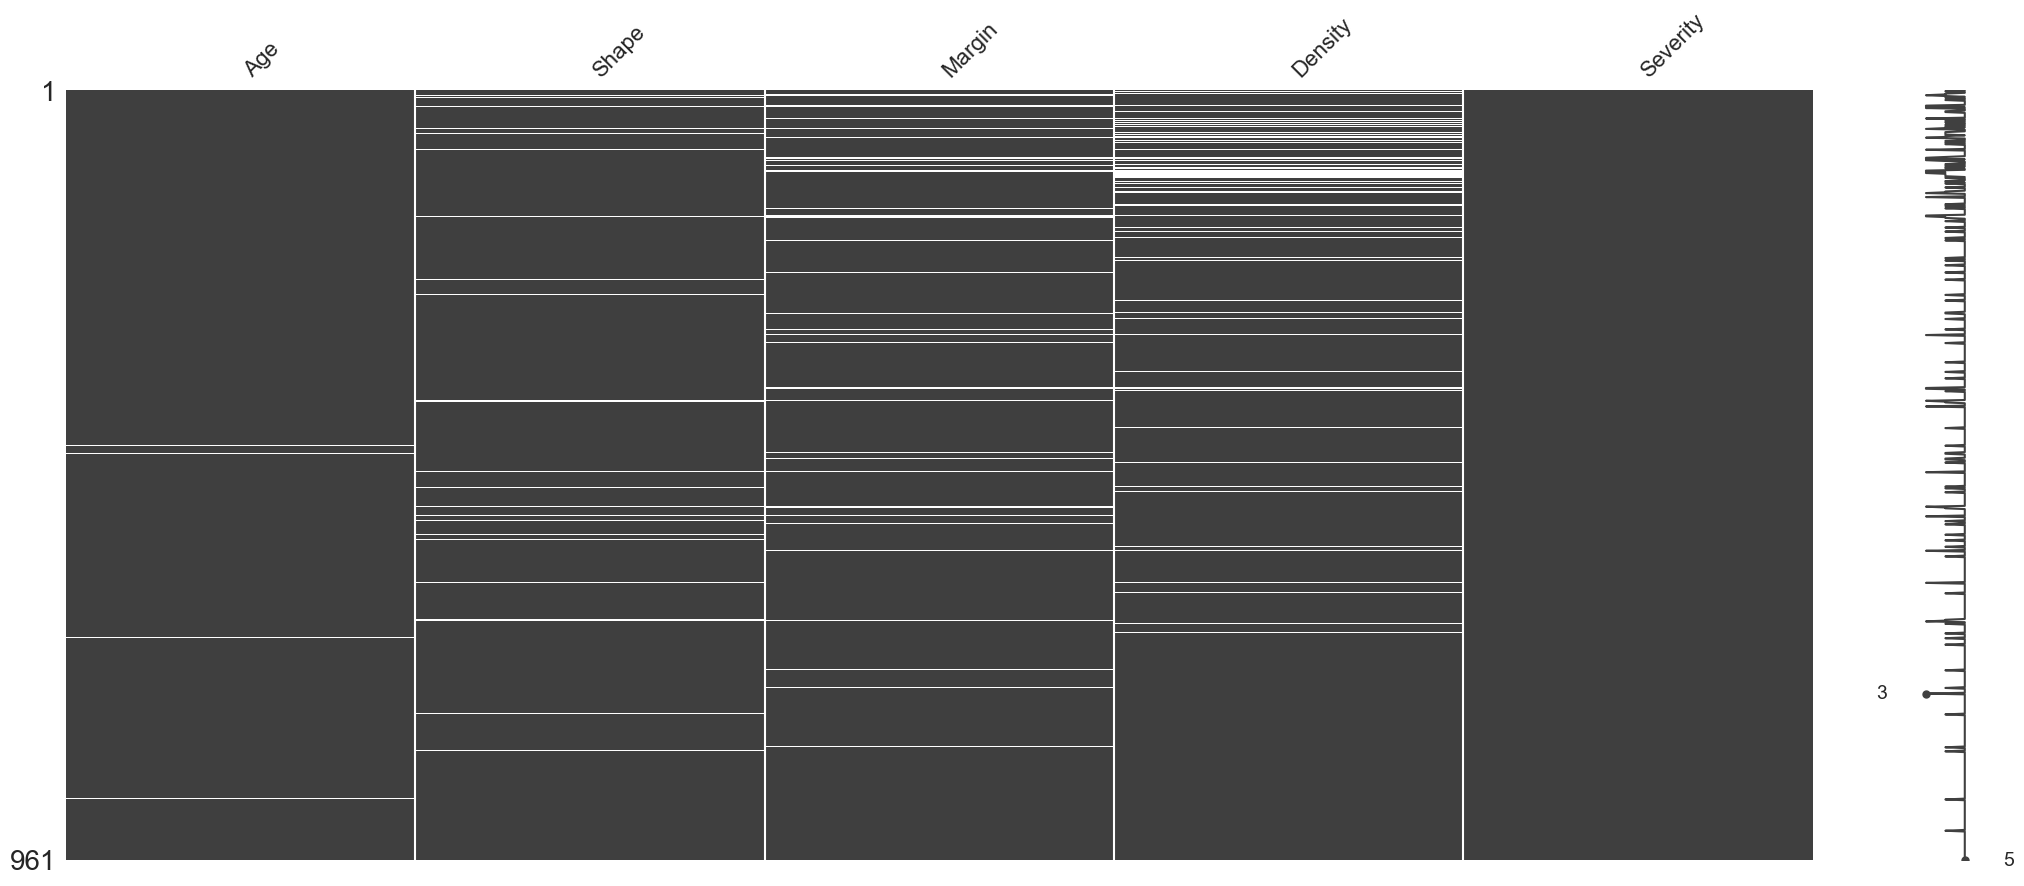

In [29]:
msno.matrix(dataset)

<Axes: >

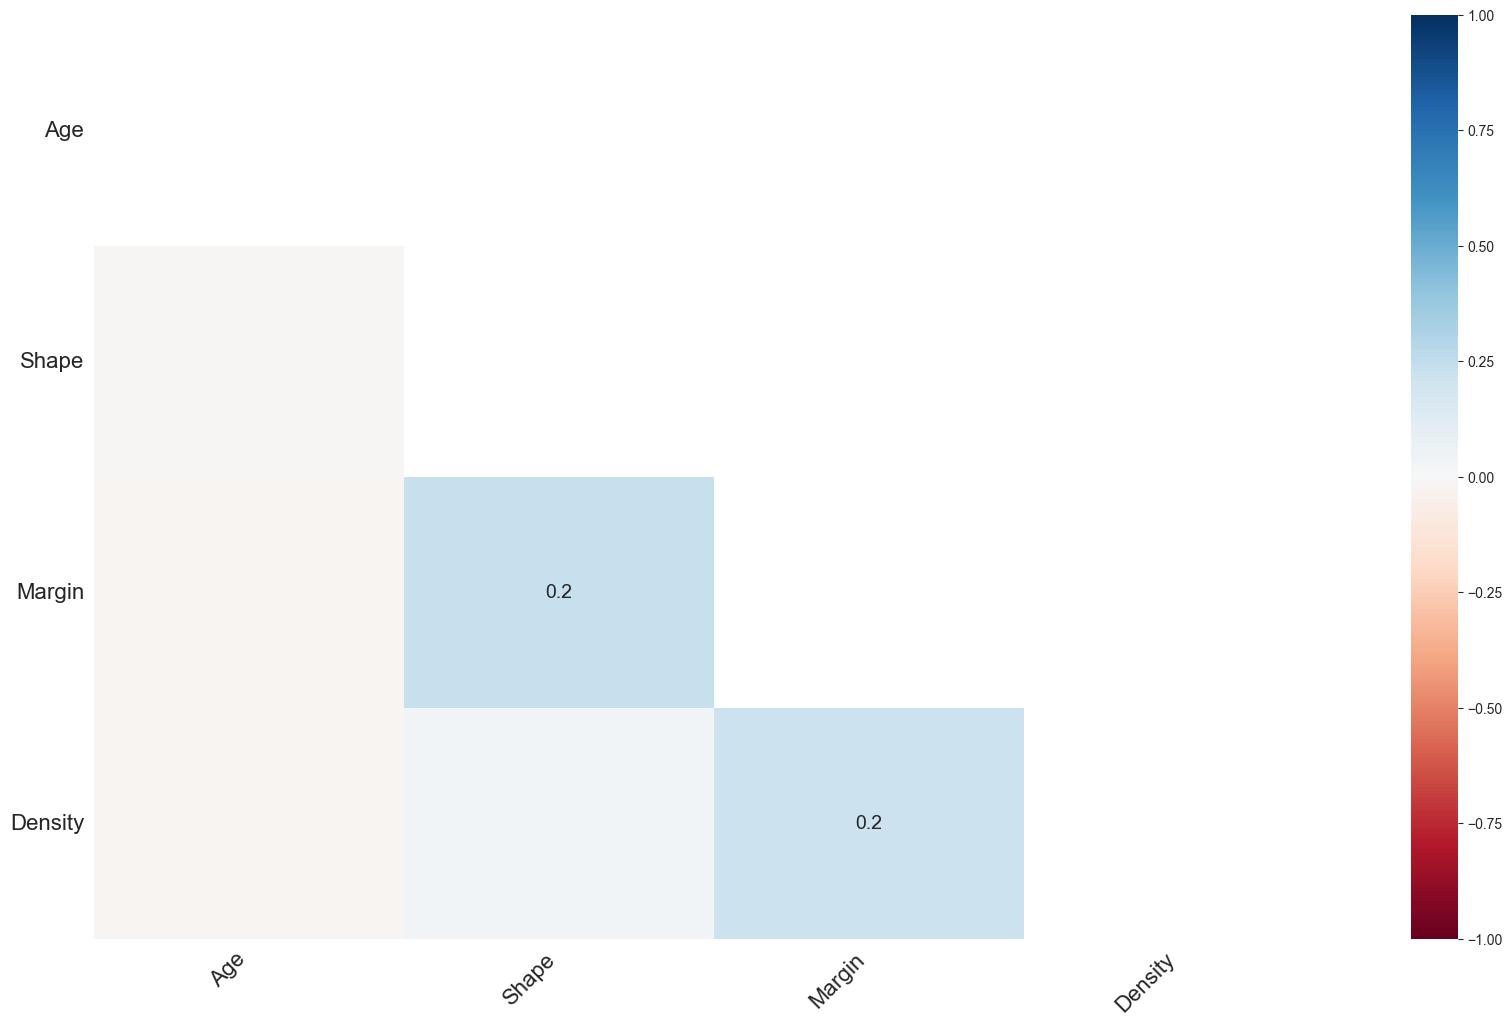

In [30]:
msno.heatmap(dataset)

<Axes: >

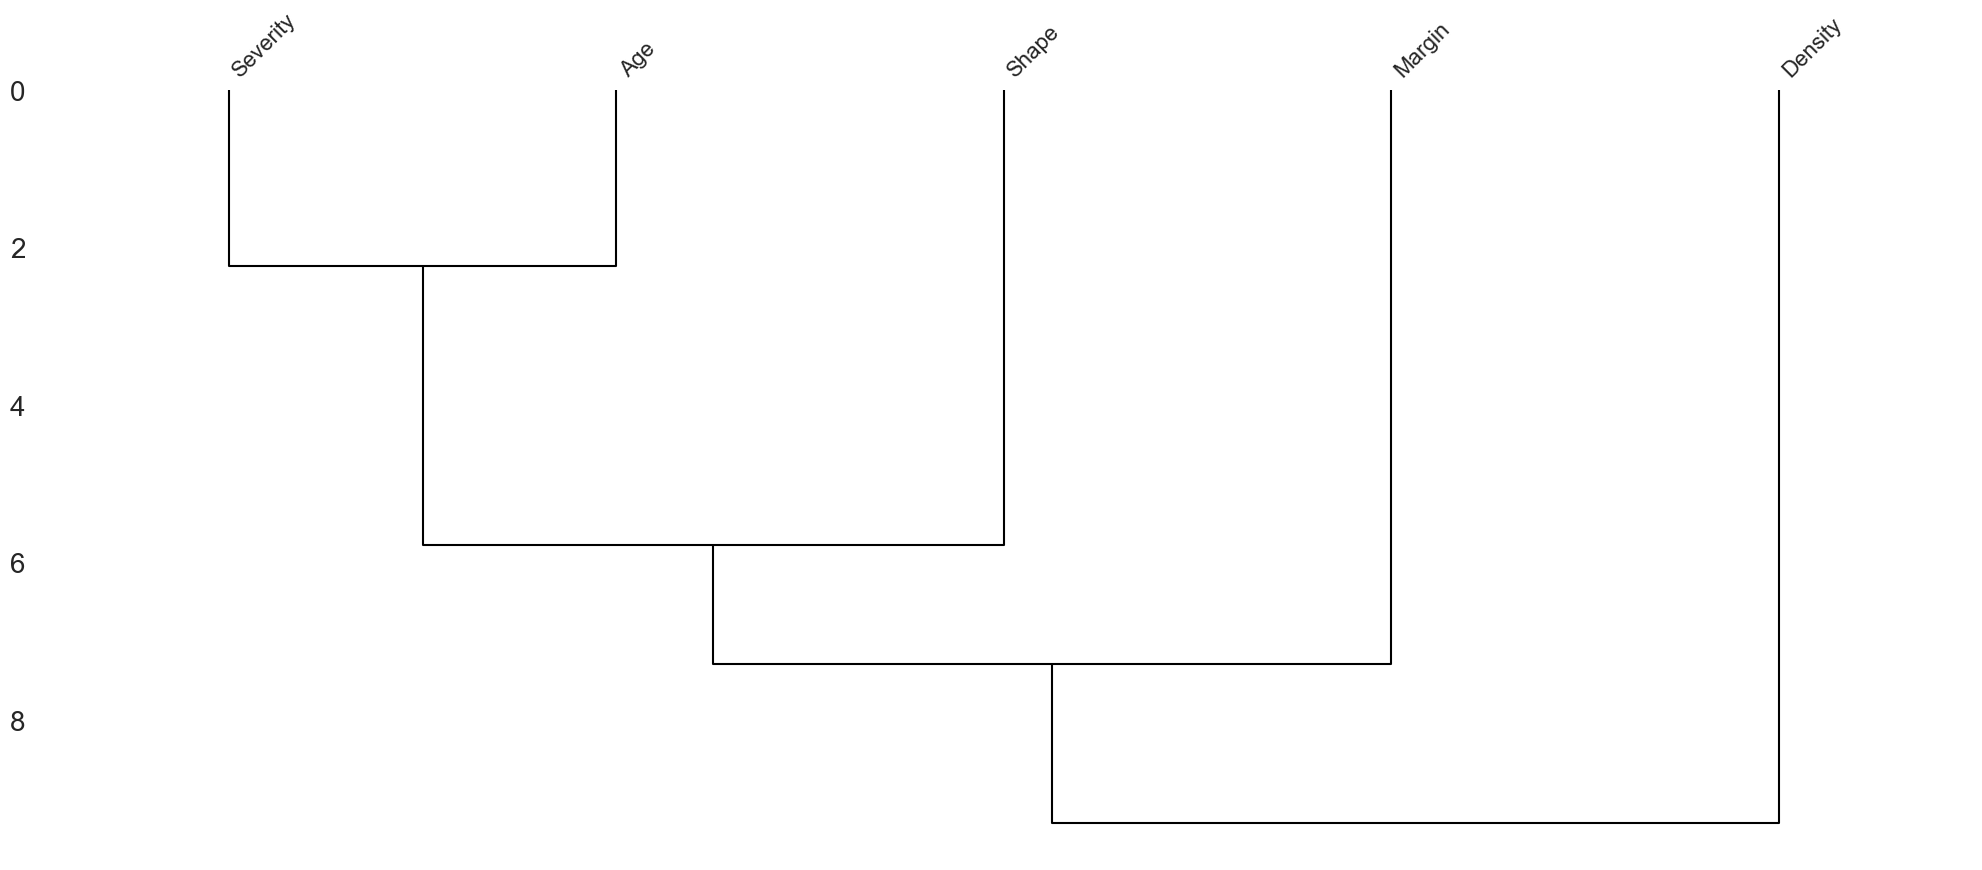

In [31]:
msno.dendrogram(dataset)

In [32]:
dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())
dataset.isnull().sum()

Age          0
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

In [33]:
knnInputer = KNNImputer(n_neighbors=3)
df_subset = dataset[['Shape','Margin','Density']]
imputed_values = knnInputer.fit_transform(df_subset)
df_imputed_subset = pd.DataFrame(imputed_values, columns=['Shape','Margin','Density'])
dataset[[ 'Shape','Margin','Density']]= df_imputed_subset

In [34]:
X,Y = dataset.drop(columns='Severity'),dataset['Severity']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [35]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train_new = scalar.fit_transform(X_train)
X_test_new = scalar.transform(X_test)

## Decision Tree

In [36]:
model = DecisionTreeClassifier(max_depth=5, random_state=0,criterion='entropy')
model.fit(X_train_new,Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)

In [37]:
y_pred = model.predict(X_test_new)

In [38]:
print(metrics.classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.73      0.75       112
           1       0.65      0.68      0.66        81

    accuracy                           0.71       193
   macro avg       0.70      0.71      0.70       193
weighted avg       0.71      0.71      0.71       193

